# Exercise 6 - Solutions

Import satpy first...

In [1]:
import satpy

1. Read the Scene that you downloaded from the data directory using SatPy.

In [5]:
dateien = ["../path/to/file.nc"]
files = {'seviri_l1b_nc' : dateien}
scn = satpy.Scene(filenames=files)

2. Load the composites "natural_color" and "convection".

In [3]:
scn.load(["natural_color","convection"])

3. Resample the fulldisk to the Dem. Rep. Kongo and its neighbours by defining your own area in Lambert Azimuthal Equal Area. Use the following settings:

  - lat and lon of origin: -3/23
  - width and height of the resulting domain: 500px
  - projection x/y coordinates of lower left: -15E5
  - projection x/y coordinates of upper right: 15E5

In [4]:
from pyresample.geometry import AreaDefinition

area_id = 'Dem. Rep. Kongo'
description = 'Dem. Rep. Kongo in Lambert Azimuthal Equal Area projection'
proj_id = 'Dem. Rep. Kongo'
proj_dict = {'proj': 'laea', 'lat_0': -3, 'lon_0': 23}
width = 500
height = 500
llx =  -15E5
lly =  -15E5
urx =  15E5
ury =  15E5
area_extent = (llx,lly,urx,ury)
area_def = AreaDefinition(area_id, proj_id, description, proj_dict, width, height, area_extent)
local_scn = scn.resample(area_def)

4. Save both loaded composites of the resampled Scene as simple png images.

In [7]:
local_scn.save_datasets(writer='simple_image',
                  datasets=["natural_color","convection"],
                  filename='{name}_{start_time:%Y%m%d_%H%M%S}.png',
                  base_dir='path/to/output/folder')

If you did everything right, the images should look like this:

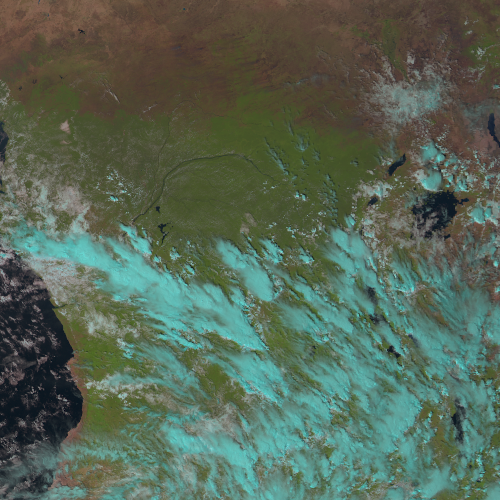

In [5]:
local_scn.show("natural_color")

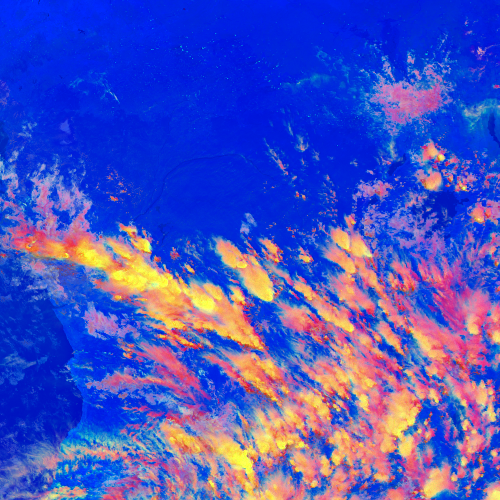

In [6]:
local_scn.show("convection")

# Notes

- Dateien habe ich bestellt weil wir komischerweise keine netcdfs haben. Bestellt ist jetzt Januar und July 2018 jede volle Stunde (sind leider immer noch ca 800GB vermutlich müssten wir das noch weiter ausdünnen da die meisten das nicht speichern können)
- Metar Stationen im Kongo wären folgende: https://www.ogimet.com/display_stations.php?lang=en&tipo=AND&isyn=&oaci=&nombre=&estado=COngo&Send=Send
  Mein Vorschlag wäre die Kinshasa / N'Djili (FZAA) Station da diese vermutlich am zuverlässigsten ist (Hauptstadt und so ;-))

# Ogimet download

Für das snippet müsstest du noch das hyfog repo installieren dann sollte es mit folgendem code klappen.<br>
Anpassen müsstest du nur noch die Zeit und das basis Verzeichnis wo du es hinspeichern möchtest

from hyfog.util.ogimet import ogimetDownload
from hyfog.util.utils import get_month_day_range
from datetime import datetime
from time import sleep
import os
from tqdm import tqdm, tqdm_notebook
import pandas as pd

def chunkIt(seq, num):
    avg = len(seq) / float(num)
    out = []
    last = 0.0
    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg

    return out

#directory where to store data (subdirs with year will be created in loop)
ogidir = "kongo_metar_synop_stations"

#starttime, endtime and frequency
timestart = datetime(2005, 1, 1, 0, 0)
timeend = datetime(2007, 12, 31, 0, 0)
month = pd.date_range(timestart, timeend, freq="MS")

station_type_id = {"synop": "64210", "metar": "FZAA"}
#if only metar or synop required delete one of them below
station_types = ["metar", "synop"]


datebar = tqdm_notebook(total=len(month)*len(station_types), leave=False)
for t in station_types:
    cbar.set_description("{} {}".format(c, t))
    for slot in month:
        datebar.set_description(slot.strftime("%Y%m"))
        stime, etime = get_month_day_range(slot)

        if t == "metar":
            station_id = station_type_id["metar"]
            src = "metar"
        elif t == "synop":
            station_id = station_type_id["synop"]
            src = "synop"

        #following code is only needed when a lot of station ids are provided
        #it will split them into chunks of 20 each
        nchunks = len(station_id)//20
        if nchunks == 0:
            nchunks +=1
        station_id_chunks = chunkIt(list(station_id), nchunks)
        
        #download chunks
        with tqdm_notebook(station_id_chunks, leave=False) as chunkbar:
            for i, chunk in enumerate(chunkbar):

                chunkbar.set_description(str(i))
                ddir = os.path.join(ogidir, slot.strftime("%Y"))
                if not os.path.exists(ddir):
                    os.makedirs(ddir)
                fi = os.path.join(ddir, t + "_" + c.lower() + slot.strftime("_%Y%m_") + "{:02d}".format(i) + ".txt")
                if os.path.isfile(fi):
                    continue

                #tor.newIdentity()

                ogimetDownload(chunk, stime, etime, source = src, filename = fi)#, tor = tor)
                sleep(4*60)

        datebar.update(1)